# The impact of water storages on flood plains

This notebook generates wofs images before and after a given date. 

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('Scripts')


dc = datacube.Datacube()

## Enter user inputs such as lat, lon and construction date

In [2]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -28.118
lon = 148.597
buffer = 15000 #This is the radius around the lat, lon to display

#These are the exceedence values on the x axis of a flow duration curve
#Extreme flooding events sometimes mess up the delta image. Take them out by putting a limit on the x-axis. 
top_flow_percentage = 20 #recommended to set to 20
flow_percentage_limit = 2.5 #recommended to set to 2.5

#Where abouts is your csv file with the gauge data located on your computer?
csv_file_location = 'Gauges/Condamine-Balonne/Culga_River_Whyenbah.csv'

#When was the water storage you are interested in constructed?
construction_date = '1998-06-01'

## Calling wofs data for days when the stream gauge was reading high flows

In [3]:
#Loading and organising guage data into a flow duration curve
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

# Set up a query which includes ALL satellite data from 1987
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1987-01-01', '2019-11-01'), # Change this date to match present day
         'crs': 'EPSG:3577'} 

#Use Dask to load satellite data. Rather than loading images, it loads parameters only. 
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {}, 
                      group_by='solar_day', 
                      **query)

gauge_data_xr = gauge_data.to_xarray()

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account user input for the FDC
high_flow = merged_data.where((merged_data.Exceedence < top_flow_percentage) & 
                              (merged_data.Exceedence > flow_percentage_limit), drop=True)

# Get list of dates when gauge was reading high flow
date_list = high_flow.time.values

print(f'You are about to load {high_flow.time.shape[0]} satellite passes')

print(f'lat = {lat}')
print(f'lon = {lon}')

You are about to load 100 satellite passes
lat = -28.118
lon = 148.597


## Load wofs images and cloud mask them

In [4]:
# Load the passes that happened during the specified flow parameters
high_flow_passes = wofs_albers.sel(time=date_list).compute()

# Cloudmask
cc = masking.make_mask(high_flow_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])
npixels_per_slice = (high_flow_passes.water.shape[1] * 
                     high_flow_passes.water.shape[2])
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
clear_high_flow_passes = high_flow_passes.water.isel(time=cloud_pixels_fraction < 0.5)

#You can un-hash these lines if you want to see a summary image of wofs for all time.
#wet = (clear_high_flow_passes == 128).sum(dim='time')
#dry = (clear_high_flow_passes == 0).sum(dim='time')
#clear = wet + dry
#frequency = wet / clear
#frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
#frequency = frequency.where(frequency!=0)
#frequency.plot(figsize = (10,8))

#print(f'This image is made of {high_flow_passes.time.shape[0]} satellite passes')

## Split the wofs data into before and after

The Before image is made of 29 satellite passes
The After image is made of 51 satellite passes


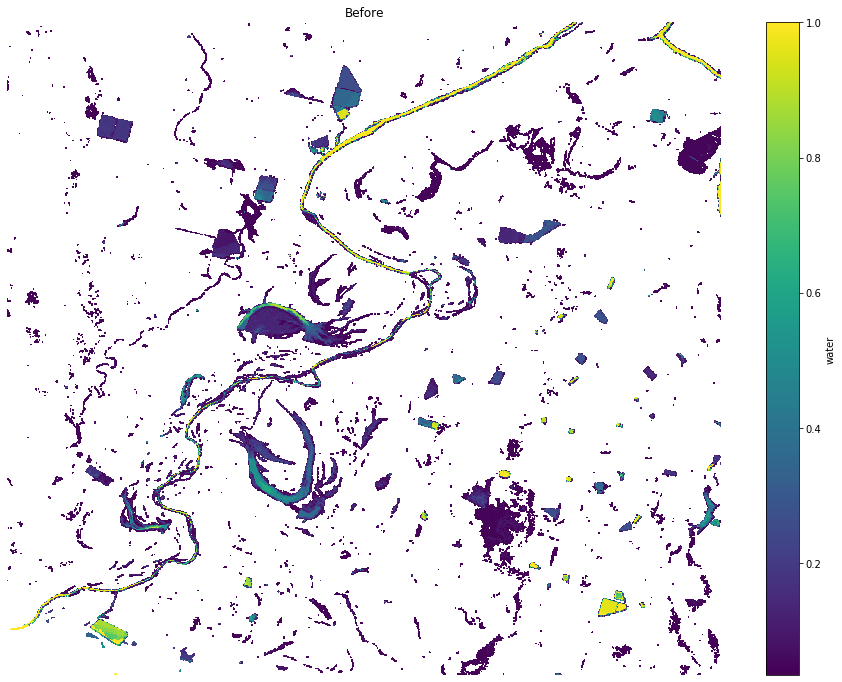

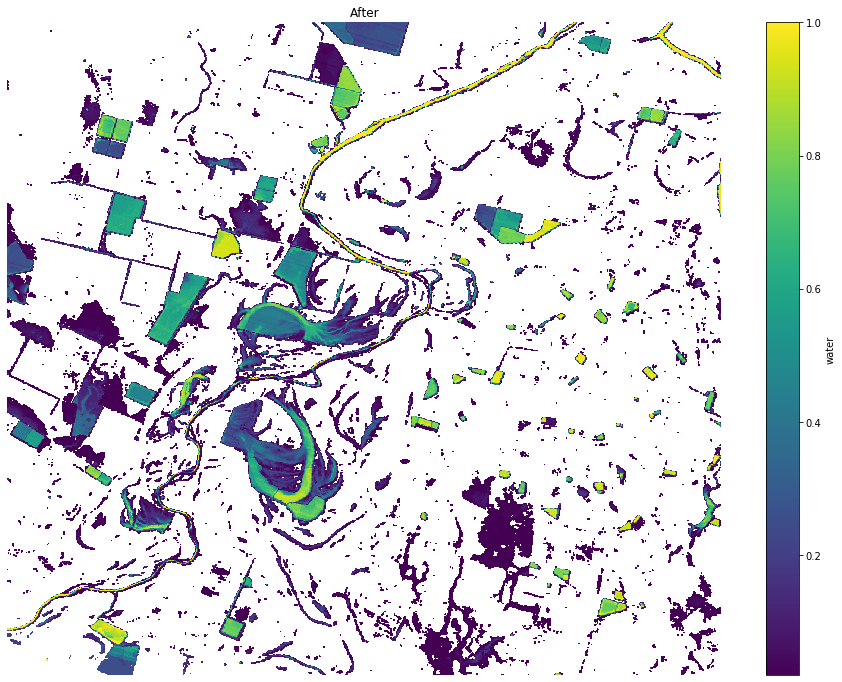

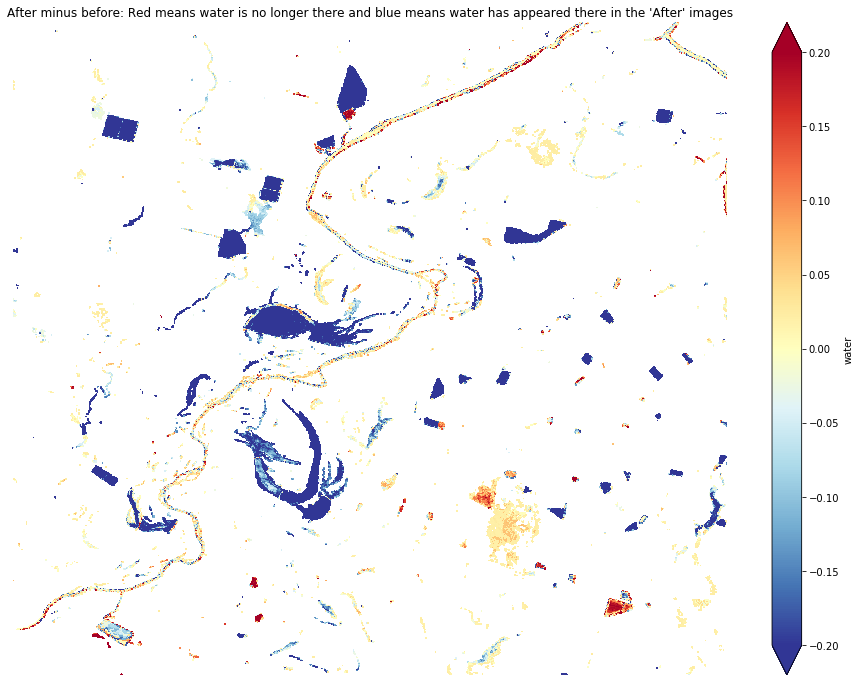

In [5]:
# Split by date into before and after legislation about floodplain harvesting
query_dates = clear_high_flow_passes

before_construction = query_dates.loc[dict(time=slice('1987-01-01', construction_date))] # Change according to date legislation became effective
after_construction = query_dates.loc[dict(time=slice(construction_date, '2020-01-01'))]

print(f'The Before image is made of {before_construction.time.shape[0]} satellite passes')
print(f'The After image is made of {after_construction.time.shape[0]} satellite passes')

#Create parameters for the image
wet = (before_construction == 128).sum(dim='time')
dry = (before_construction == 0).sum(dim='time')
clear = wet + dry
frequency_before = wet / clear
frequency_before = frequency_before.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_before = frequency_before.where(frequency_before !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_before.plot(figsize = (16, 12))
plt.axis('off')
plt.title('Before')
plt.show()


#Create parameters for the image
wet = (after_construction == 128).sum(dim='time')
dry = (after_construction == 0).sum(dim='time')
clear = wet + dry
frequency_after = wet / clear
frequency_after = frequency_after.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency_after = frequency_after.where(frequency_after !=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency_after.plot(figsize = (16, 12))
plt.axis('off')
plt.title('After')
plt.show()

delta = frequency_before - frequency_after

# Plotting the image
delta.plot(figsize = (16, 12), vmin = -0.2, vmax = 0.2, cmap = 'RdYlBu_r')
plt.axis('off')
plt.title("After minus before: Red means water is no longer there and blue means water has appeared there in the 'After' images")
plt.show()

## (optional) Check the distribution of the passes to make sure it's a good representation

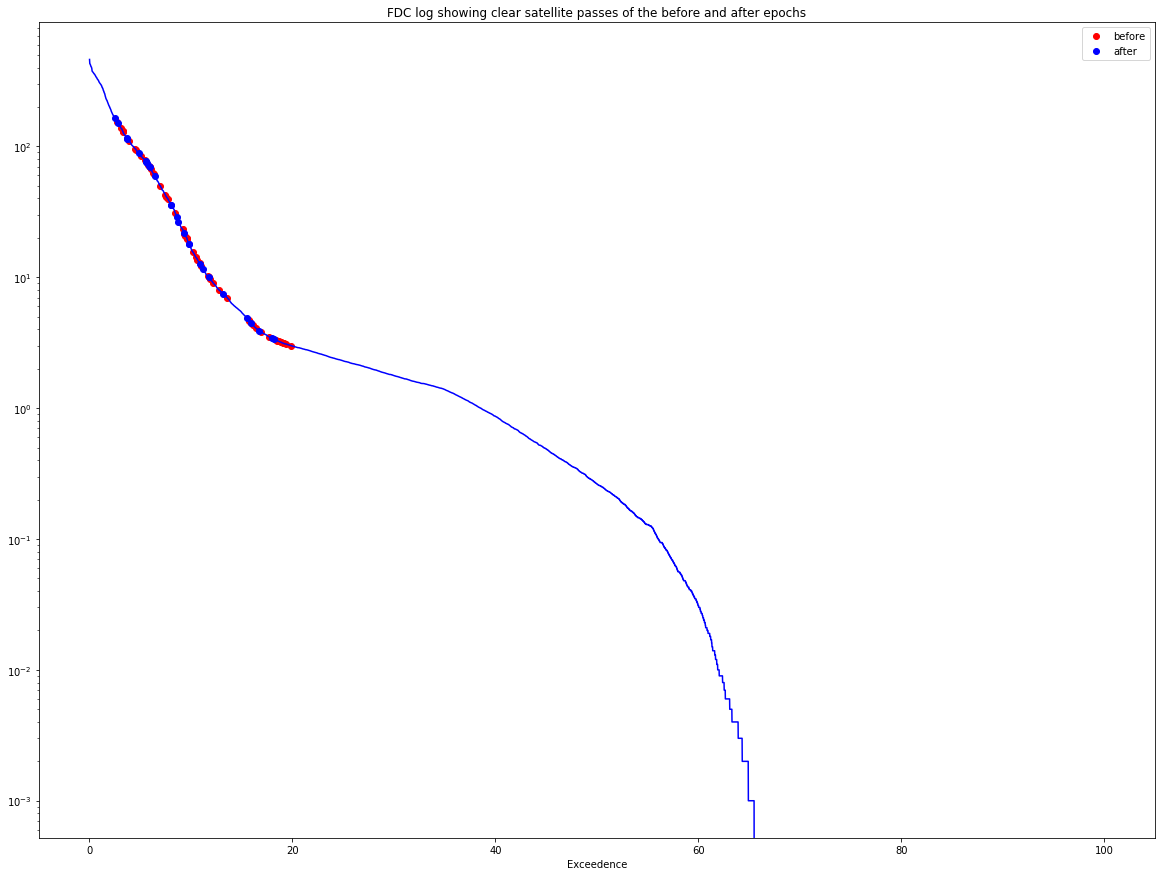

In [6]:
#Now take the clear passes and make a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_high_flow_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called time
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

before = clear_merged_data['1987-01-10':'2008-06-01']
after  = clear_merged_data['2008-06-01':]

# Plot clear satellite passes with a top 20% flowrate over a flow duration curve
ax = before.plot(x='Exceedence', marker = 'o', color = 'red', linestyle='None',
                y='Value',
                logy=True,
                title='FDC log showing clear satellite passes of the before and after epochs', figsize = (20,15))
after.plot(x='Exceedence', logy=True, y='Value', ax=ax, marker = 'o', color = 'blue', linestyle='None')
gauge_data.plot(x='Exceedence', y='Value', logy=True, ax=ax, color = 'blue')
ax.legend(["before", "after"]);

Great, now all that's left to do if find a way to automatically input lat, lon and construction date by simply choosing a water storage from the dea waterbodies shapefile. 